In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [2]:
cd "/content/drive/My Drive/major"

/content/drive/My Drive/major


In [3]:
ls

'=0.6.2'                       Models/
'=1.0.0'                       ngrok*
'=.20'                         ngrok-stable-linux-amd64.zip
 all_sig_waves.npy             noise/
 augmented.csv                 None/
 augmented_data_unraveled.h5   requirement_new.txt
 birdsong_metadata.csv         songs/
 log/                          spare.ipynb
 mfcc+delta.npy                test/
 mfcc_label.npy                test_data_unraveled.h5
 mfcc_only.npy                 train/


In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [0]:
import psutil
import humanize
import os
import GPUtil as GPU

# XXX: only one GPU on Colab and isn’t guaranteed

In [8]:
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


Gen RAM Free: 12.2 GB  | Proc size: 889.0 MB
GPU RAM Free: 14858MB | Used: 221MB | Util   1% | Total 15079MB


In [9]:
!pip install sklearn

In [10]:
from keras.layers import Conv2D,Reshape,MaxPooling2D,AveragePooling2D
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense,Flatten
from keras.optimizers import Adam
from keras.layers import Dropout
#import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
#from scipy import misc
#from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img,array_to_img,img_to_array
import pandas as pd
#import seaborn as sns
import gc
gc.collect()

Using TensorFlow backend.


0

In [11]:
meta_train = pd.read_csv('augmented.csv')
X,y  = [],[]
classes_taken = len(pd.unique(meta_train.speices))
#for i in meta_train.name[:(classes_taken*625)]:
#    X.append(img_to_array(load_img('new_aug_train/' + i + '.png')).astype(dtype = np.float32))
    
import h5py
#with h5py.File('augmented_data_unraveled.h5', 'w') as hf:
#    hf.create_dataset("data",data=X)




X=[]
with h5py.File('augmented_data_unraveled.h5', 'r') as hf:
    X= hf['data'][:]
X = np.array(X)
print(pd.unique(meta_train.speices))
print(X.shape)
gc.collect()

X = np.array(X)/255
y = pd.get_dummies(meta_train.speices[:classes_taken*625]).values

['arvensis' 'borin' 'calandra' 'cannabina' 'coelebs' 'megarhynchos'
 'merula' 'montanus' 'philomelos' 'rubecula' 'rustica' 'schoenobaenus'
 'scirpaceus' 'stellata' 'trochilus']
(9375, 129, 295, 3)


In [0]:
train_x,test_x,train_y,test_y =  train_test_split(X,y,test_size = .1)

In [0]:
from keras.models import Model
from keras.optimizers import Nadam
from keras.layers import BatchNormalization, Convolution2D, Input, merge
from keras.layers.core import Activation, Layer
from keras.initializers import glorot_uniform
from keras.layers.merge import Add
import keras

In [0]:
def identity_block(X, f, filters, stage):
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + '_branch'
    bn_name_base = 'bn' + str(stage) + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    #X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    #X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    #X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [0]:
def Unit(x,filters,pool=False):
    res = x
    if pool:
        x = MaxPooling2D(pool_size=(2, 2),padding='same')(x)
        res = Conv2D(filters=filters,kernel_size=[1,1],strides=(2,2),padding="same")(res)
    out = BatchNormalization()(x)
    out = Activation("relu")(out)
    out = Conv2D(filters=filters, kernel_size=[3, 3], strides=[1, 1], padding="same")(out)

    out = BatchNormalization()(out)
    out = Activation("relu")(out)
    out = Conv2D(filters=filters, kernel_size=[1, 1], strides=[1, 1], padding="same")(out)

    out = keras.layers.add([res,out])

    return out


In [0]:
def MiniModel(input_shape):
    images = Input(input_shape)
    net = Conv2D(filters=8, kernel_size=3, strides=[1, 1], padding="same")(images)
    #net = identity_block(net, 3, (8,16,8), 1)
    #net = identity_block(net, 5, (32,64,32), 2)
    #net = identity_block(net, 3, (32,64,32), 3)
    net = Unit(net,8)
    #net = Unit(net,8)
    #net = Unit(net,8)

    net = Unit(net,16,pool=True)
    #net = Unit(net,16)
    #net = Unit(net,16)
    
    net = Unit(net,32,pool=True)
    
    net = AveragePooling2D(pool_size=(4,4))(net)
    net = Flatten()(net)
    net = Dense(units=1024,activation='relu')(net)
    net = Dense(units=15,activation="softmax")(net)

    model = Model(inputs=images,outputs=net)

    return model

In [19]:
input_shape=(129,295,3)
model = MiniModel(input_shape)

#Print a Summary of the model

model.summary()
#Specify the training components
model.compile(optimizer=Adam(0.001),loss="categorical_crossentropy",metrics=["accuracy"])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 129, 295, 3)  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 129, 295, 8)  224         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 129, 295, 8)  32          conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 129, 295, 8)  0           batch_normalization_7[0][0]      
__________________________________________________________________________________________________
conv2d_11 

In [23]:
history = model.fit(x=train_x,y=train_y,validation_data=[test_x,test_y],
                    epochs=10,batch_size=10, verbose=1)

Train on 8437 samples, validate on 938 samples
Epoch 1/10
8437/8437 [==============================] - 21s 3ms/step - loss: 2.8525 - acc: 0.8145 - val_loss: 2.1241 - val_acc: 0.8667
Epoch 2/10
8437/8437 [==============================] - 22s 3ms/step - loss: 1.8011 - acc: 0.8856 - val_loss: 1.0751 - val_acc: 0.9296
Epoch 3/10
8437/8437 [==============================] - 21s 2ms/step - loss: 1.1477 - acc: 0.9259 - val_loss: 1.0550 - val_acc: 0.9328
Epoch 4/10
8437/8437 [==============================] - 21s 2ms/step - loss: 0.2970 - acc: 0.9776 - val_loss: 0.0655 - val_acc: 0.9893
Epoch 5/10
8437/8437 [==============================] - 21s 2ms/step - loss: 0.0736 - acc: 0.9931 - val_loss: 0.0663 - val_acc: 0.9915
Epoch 6/10
8437/8437 [==============================] - 21s 3ms/step - loss: 0.0234 - acc: 0.9979 - val_loss: 0.0026 - val_acc: 0.9989
Epoch 7/10
8437/8437 [==============================] - 21s 2ms/step - loss: 0.2220 - acc: 0.9827 - val_loss: 1.4862 - val_acc: 0.8891
Epoch 8/

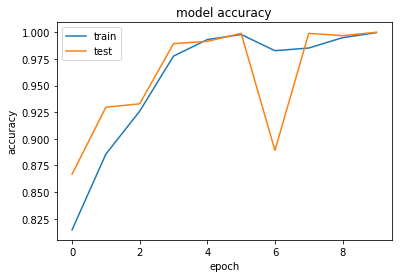

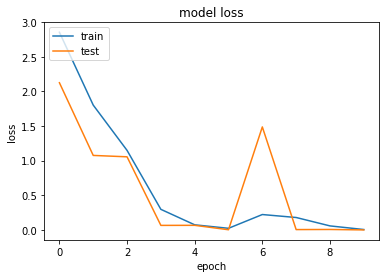

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [0]:
meta_test = pd.read_csv('test/test_signal.csv')
X = []
classes = pd.unique(meta_train.speices)


'''for i in meta_test.name:
    X.append(img_to_array(load_img('test/' + i)).astype(dtype = np.float32))
X = np.array(X)/255
gc.collect()

with h5py.File('test_data_unraveled.h5', 'w') as hf:
    hf.create_dataset("data",data=X)
'''


with h5py.File('test_data_unraveled.h5', 'r') as hf:
    X= hf['data'][:]


act = []
pre = []
tiktok = 0
total = 0
for i in range(len(classes)):
    x= meta_test[meta_test.speices == classes[i]]
    for j in x.name:
        img = img_to_array(load_img('test/' + j)).reshape((1,129,295,3))
        #print(img.shape)
        predicted = np.argmax(model.predict(img))
        #pre.append(predicted)
        if predicted == i:
           tiktok += 1
        total += 1


gc.collect()
print("total: {0} predicetd: {1}".format(total,tiktok))
print('accuracy: ',tiktok/total)


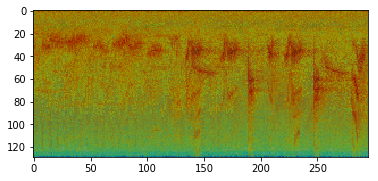

In [0]:
import matplotlib.pyplot as plt
plt.imshow(train_x[0])